# Preprocessing

## Import libs

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import spacy
nlp_spacy = spacy.load('pt_core_news_sm')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\juceg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juceg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Loading and Cleansing Datasets

In [117]:
def load_and_filter_orders(file_path):
    df_orders = pd.read_csv(file_path)
    df_orders = df_orders[['order_id', 'order_purchase_timestamp']]
    df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'])
    print(f'Number of orders: {len(df_orders)}')
    return df_orders

def load_and_filter_order_items(file_path):
    df_orders_items = pd.read_csv(file_path)
    print(f'Number of items: {len(df_orders_items)}')
    df_orders_items = df_orders_items[df_orders_items['order_item_id'] == 1]
    df_orders_items = df_orders_items[['order_id', 'product_id', 'price', 'order_item_id']]
    print(f'Number of items with only 1 product: {len(df_orders_items)}')
    return df_orders_items

def load_and_filter_products(file_path):
    df_products = pd.read_csv(file_path)
    df_products = df_products[['product_id', 'product_category_name']]
    df_products = df_products[~df_products['product_category_name'].isna()]
    print(f'Number of products: {len(df_products)}')
    print(f'Number of product categories: {len(df_products["product_category_name"].unique())}')
    return df_products

def load_and_filter_reviews(file_path):
    df_reviews = pd.read_csv(file_path)
    df_reviews = df_reviews[['order_id', 'review_score', 'review_comment_message', 'review_creation_date']]
    df_reviews['review_creation_date'] = pd.to_datetime(df_reviews['review_creation_date'])
    print(f'Number of registered reviews: {len(df_reviews)}')
    return df_reviews

def merge_dataframes(df_orders, df_orders_items, df_reviews, df_products):
    df_full = pd.merge(df_orders, df_orders_items.drop_duplicates(subset=['order_id', 'order_id']), on='order_id')
    df_full = pd.merge(df_full, df_reviews, on='order_id', how='inner')
    df_full = pd.merge(df_full, df_products, on='product_id', how='inner')

    df_full = df_full[['order_purchase_timestamp', 'review_score', 'review_comment_message',
                       'review_creation_date', 'product_category_name', 'price']]

    df_full = df_full[~df_full['review_comment_message'].isna()]
    print(f'Number of reviews with comments: {len(df_full)}')

    print(f"Data period: {df_full['order_purchase_timestamp'].min()} - {df_full['order_purchase_timestamp'].max()}")

    return df_full

# Load and filter orders data
df_orders = load_and_filter_orders('./data/olist_orders_dataset.csv')

# Load and filter order items data
df_orders_items = load_and_filter_order_items('./data/olist_order_items_dataset.csv')

# Load and filter products data
df_products = load_and_filter_products('./data/olist_products_dataset.csv')

# Load and filter reviews data
df_reviews = load_and_filter_reviews('./data/olist_order_reviews_dataset.csv')

# Merge dataframes
df_full = merge_dataframes(df_orders, df_orders_items, df_reviews, df_products)

# Display the resulting dataframe
df_full.head()

Number of orders: 99441
Number of items: 112650
Number of items with only 1 product: 98666
Number of products: 32341
Number of product categories: 73
Number of registered reviews: 99224
Number of reviews with comments: 39844
Data period: 2016-09-04 21:15:19 - 2018-09-03 09:06:57


,order_purchase_timestamp,review_score,review_comment_message,review_creation_date,product_category_name,price
0,2017-10-02 10:56:33,4,"Não testei o produto ainda, mas ele veio corre...",2017-10-11,utilidades_domesticas,29.99
1,2017-08-15 18:29:31,4,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19,utilidades_domesticas,29.99
2,2017-08-02 18:24:47,5,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08,utilidades_domesticas,29.99
4,2018-07-24 20:41:37,4,Muito bom o produto.,2018-08-08,perfumaria,118.70
5,2018-06-11 10:25:52,5,Entrega antes da data marcada. Excelente,2018-06-20,perfumaria,119.90


## Explorer Review Score

In [118]:
df_reviews = df_full[['review_score','review_comment_message','review_creation_date']]
df_reviews['review_creation_date'] = pd.to_datetime(df_reviews['review_creation_date'])
df_reviews = df_reviews[~df_reviews['review_comment_message'].isna()]
df_reviews.reset_index(drop=True, inplace=True)
df_reviews.head()

,review_score,review_comment_message,review_creation_date
0,4,"Não testei o produto ainda, mas ele veio corre...",2017-10-11
1,4,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19
2,5,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08
3,4,Muito bom o produto.,2018-08-08
4,5,Entrega antes da data marcada. Excelente,2018-06-20


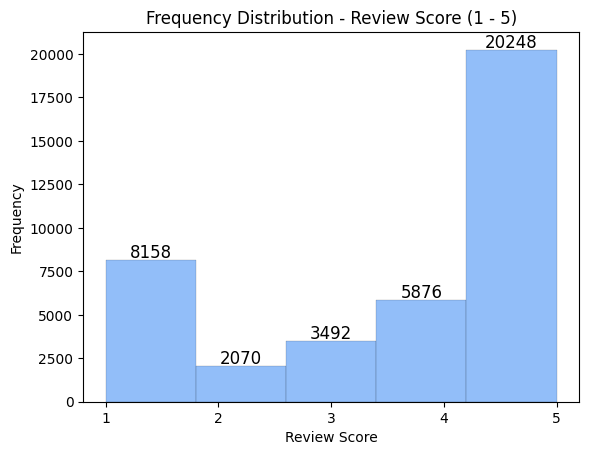

In [119]:
# Create histogram with all stars
ax = sns.histplot(df_reviews['review_score'], bins=5, kde=False, color='#6EA9F7', stat="count", linewidth=0.1)
plt.title('Frequency Distribution - Review Score (1 - 5)')
plt.xlabel('Review Score')
plt.ylabel('Frequency')

plt.xticks([1, 2, 3, 4, 5])

# Add the Frequency each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5),
                textcoords='offset points')

plt.show()

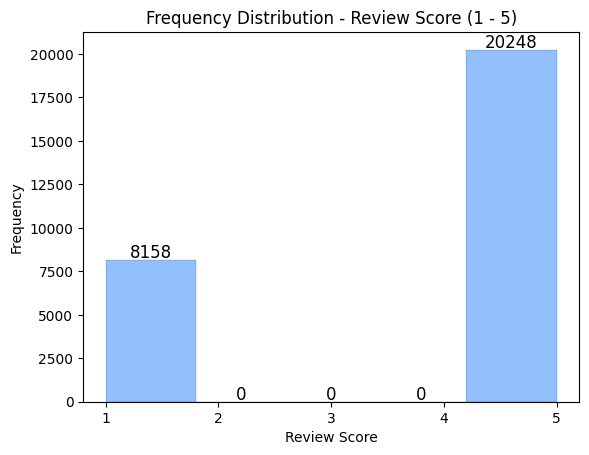

In [120]:
df_reviews = df_reviews[((df_reviews['review_score'] == 1) | (df_reviews['review_score'] == 5))]
# Crie um histograma usando Seaborn
ax = sns.histplot(df_reviews['review_score'], bins=5, kde=False, color='#6EA9F7', stat="count", linewidth=0.1)
plt.title('Frequency Distribution - Review Score (1 - 5)')
plt.xlabel('Review Score')
plt.ylabel('Frequency')

plt.xticks([1, 2, 3, 4, 5])

# Add the Frequency each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5),
                textcoords='offset points')

plt.show()

## Create Label Feture in dataset

In [121]:
df_reviews['label'] = np.where(df_reviews['review_score'] == 5, 1, 0)
display(df_reviews['label'].value_counts())
display(df_reviews)

label
1    20248
0     8158
Name: count, dtype: int64

,review_score,review_comment_message,review_creation_date,label
2,5,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08,1
4,5,Entrega antes da data marcada. Excelente,2018-06-20,1
5,5,estou satisfeito,2018-08-15,1
6,5,Mais uma ve satisfeito,2018-05-09,1
7,5,"Muito boa a compra, dentro do prazo.",2017-12-08,1
...,...,...,...,...
39837,1,"COMPREI 04, MAS SO RECEBI 02",2017-11-28,0
39839,1,"este produto que eu comprei, é uma propaganda ...",2017-05-30,0
39841,5,Muito bom produto,2018-08-18,1
39842,5,Satisfação garantida,2018-03-17,1


##  Text Preprocessing

Lowercasing: This involves converting all the text to lowercase, which helps in reducing the complexity and variability of the text.

Tokenization: It's the process of breaking down the text into smaller units (tokens), typically words or terms. This is a fundamental step for many other NLP operations.

Stopword Removal: This involves eliminating common words (like "and", "the", "in" in English, or "e", "até","um" in Português) that generally do not add significant meaning to the content analysis.

Lemmatization: This process converts words to their base or lemma form, aiding in the analysis by reducing the variation in word forms.

In [122]:
def to_lowercase(text):
    return text.lower()

def tokenize(text):
    return word_tokenize(text)

# A palavra "não" deve ser mantida pois ela pode dar sentido oposto na frase
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('portuguese')) - set(['não'])
    return [token for token in tokens if token not in stop_words]

def lemmatize(tokens):
    doc = nlp_spacy(' '.join(tokens))
    return [token.lemma_ for token in doc]


In [123]:
df_reviews['processed_comments'] = df_reviews['review_comment_message'].apply(to_lowercase)
df_reviews['processed_comments'] = df_reviews['processed_comments'].apply(tokenize)
df_reviews['processed_comments'] = df_reviews['processed_comments'].apply(remove_stopwords)
df_reviews['processed_comments'] = df_reviews['processed_comments'].apply(lemmatize)
df_reviews['processed_review_comment'] = df_reviews['processed_comments'].apply(' '.join)
df_reviews.drop(columns='processed_comments', inplace=True)
df_reviews

,review_score,review_comment_message,review_creation_date,label,processed_review_comment
2,5,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08,1,"achar pequeno pra seis xícara , bom produto"
4,5,Entrega antes da data marcada. Excelente,2018-06-20,1,entregar antes data marcar . excelente
5,5,estou satisfeito,2018-08-15,1,satisfeito
6,5,Mais uma ve satisfeito,2018-05-09,1,ve satisfeito
7,5,"Muito boa a compra, dentro do prazo.",2017-12-08,1,"bom compra , dentro prazo ."
...,...,...,...,...,...
39837,1,"COMPREI 04, MAS SO RECEBI 02",2017-11-28,0,"compr 04 , so recebir 02"
39839,1,"este produto que eu comprei, é uma propaganda ...",2017-05-30,0,"produto compr , propaganda enganozar , pois su..."
39841,5,Muito bom produto,2018-08-18,1,bom produto
39842,5,Satisfação garantida,2018-03-17,1,satisfação garantir


## Clear processed_review_comment

In [135]:
nan_rows = df_reviews[(df_reviews['processed_review_comment'].isna()) | (df_reviews['processed_review_comment'] == '')]
df_reviews_cleaned = df_reviews.drop(nan_rows.index)

records_current = len(df_reviews_cleaned)
records_old = len(df_reviews)
print(f'Current Records: {records_current}')
print(f'Old Records: {records_old}')
print(f'Removed:{records_old-records_current}')

Current Records: 28379
Old Records: 28406
Removed:27


## Save df_reviews preprocessed

In [136]:
df_reviews_cleaned.to_csv('./data/product_reviews_preprocessed.csv',index=False)